In [3]:
import numpy as np
import pandas as pd
import requests
import shioaji as sj
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from matplotlib.dates import date2num
from mplfinance.original_flavor import candlestick_ohlc
import os



# 建立API物件，simulation=True是代表測試帳號
api = sj.Shioaji(simulation=True)

#登入你的key
accounts = api.login("","")



Response Code: 0 | Event Code: 0 | Info: host '210.59.255.161:80', hostname '210.59.255.161:80' IP 210.59.255.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total connection attempt 1 of 1) | Event: Session up


In [9]:
# csv轉成多個df
# 讀取Csv檔案
csv_file = './2023_trade_record/202310-Table.csv'
# 提取文件名
csv_file_name = os.path.basename(csv_file)
trades = pd.read_csv(csv_file,names=['stock_code','buy_date','sell_date','buy_price','sell_price'])

trades.columns = trades.iloc[0]
trades=trades.loc[1:]


# 將 'buy_date' 和 'sell_date' 列轉換為日期格式
trades['buy_date'] = pd.to_datetime(trades['buy_date'])
trades['sell_date'] = pd.to_datetime(trades['sell_date'])

# 將 'buy_price' 和 'sell_price' 列轉換為浮點數格式
trades['buy_price'] = trades['buy_price'].astype(float)
trades['sell_price'] = trades['sell_price'].astype(float)

# 根据 stock_code 分组
grouped = trades.groupby('stock_code')

# 将每个组转换为单独的 DataFrame，并存储在列表中
dfs = []
for name, group in grouped:
     # 重置索引从 0 开始
    group_reset_index = group.reset_index(drop=True)
    dfs.append(group_reset_index.copy())

# 打印每个 stock_code 的 DataFrame
# for idx, df in enumerate(dfs):
#      print(df)
    
#dfs[1].iloc[0].stock_code

for stock_df in dfs:
    print(stock_df.iloc[0].stock_code)

dfs

1319
2363
2402
2465
3036
3325
3483
3715
6122
6139
8054


[0 stock_code   buy_date  sell_date  buy_price  sell_price
 0       1319 2023-10-12 2023-10-16       84.9        83.6,
 0 stock_code   buy_date  sell_date  buy_price  sell_price
 0       2363 2023-10-11 2023-10-24      39.55        50.1
 1       2363 2023-10-12 2023-10-24      43.35        50.1
 2       2363 2023-10-25 2023-11-03      54.00        53.3,
 0 stock_code   buy_date  sell_date  buy_price  sell_price
 0       2402 2023-10-03 2023-10-03      41.75        39.8,
 0 stock_code   buy_date  sell_date  buy_price  sell_price
 0       2465 2023-10-12 2023-10-19       50.2        45.3,
 0 stock_code   buy_date  sell_date  buy_price  sell_price
 0       3036 2023-10-30 2023-10-31      119.0       118.0,
 0 stock_code   buy_date  sell_date  buy_price  sell_price
 0       3325 2023-10-05 2023-10-05       41.4        41.8,
 0 stock_code   buy_date  sell_date  buy_price  sell_price
 0       3483 2023-10-16 2023-10-30      154.5       140.5
 1       3483 2023-10-17 2023-10-30      147.5    

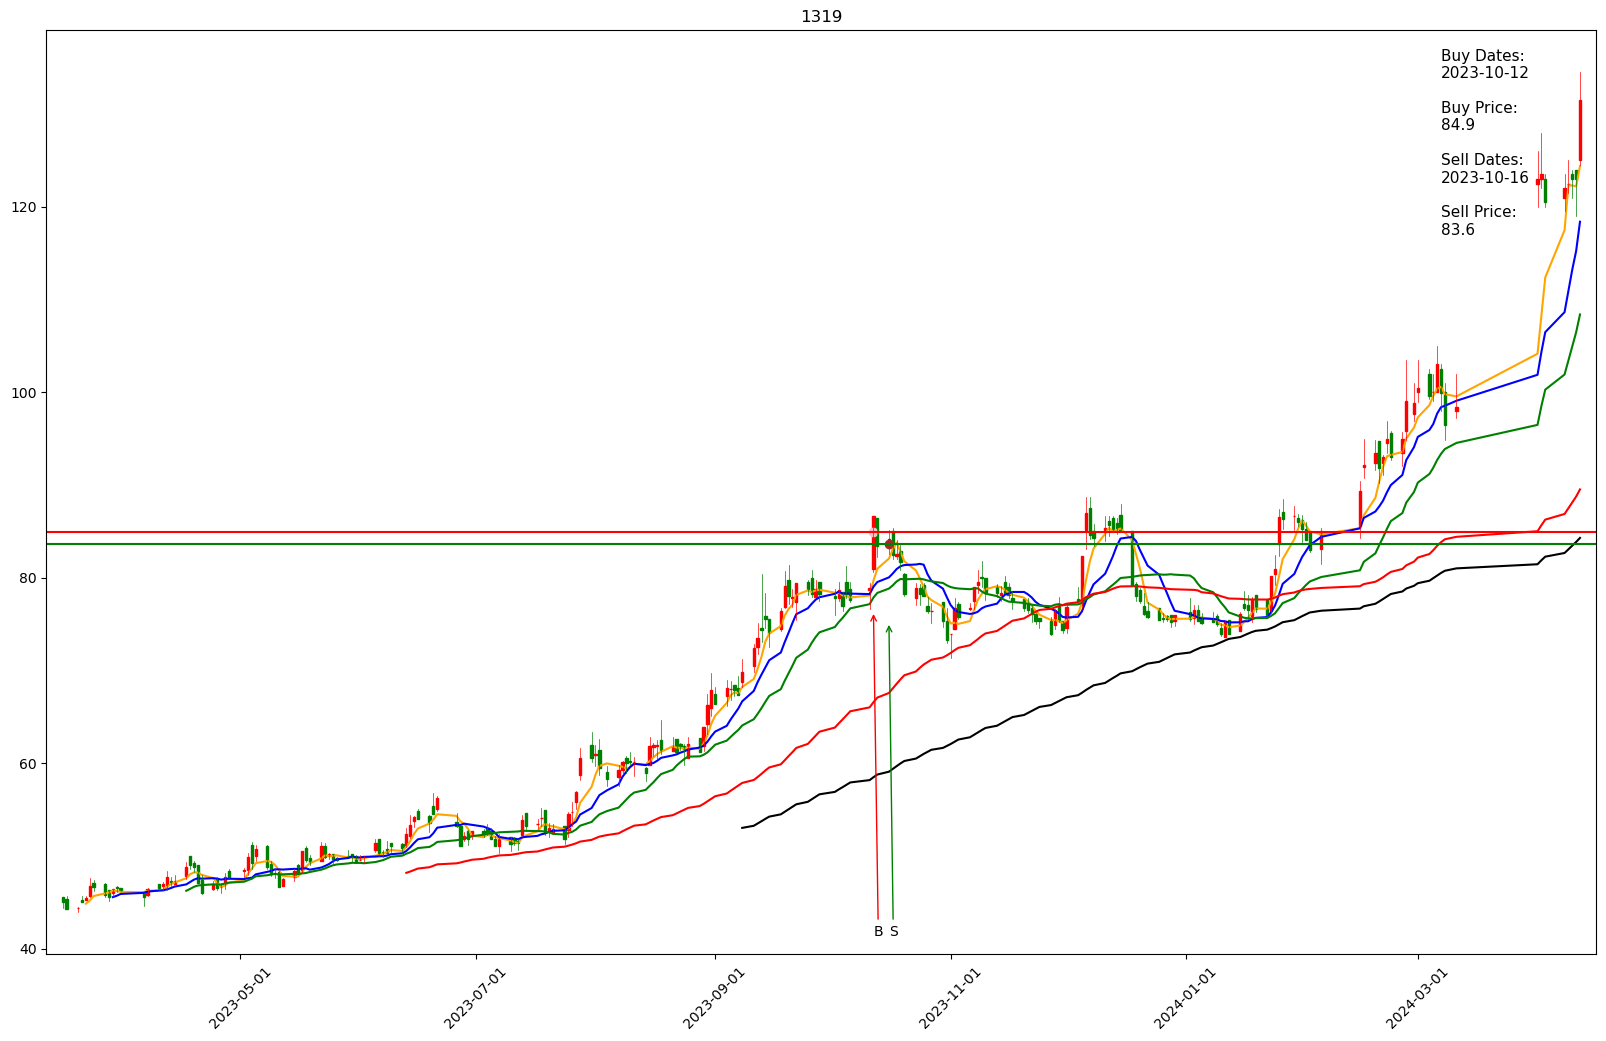

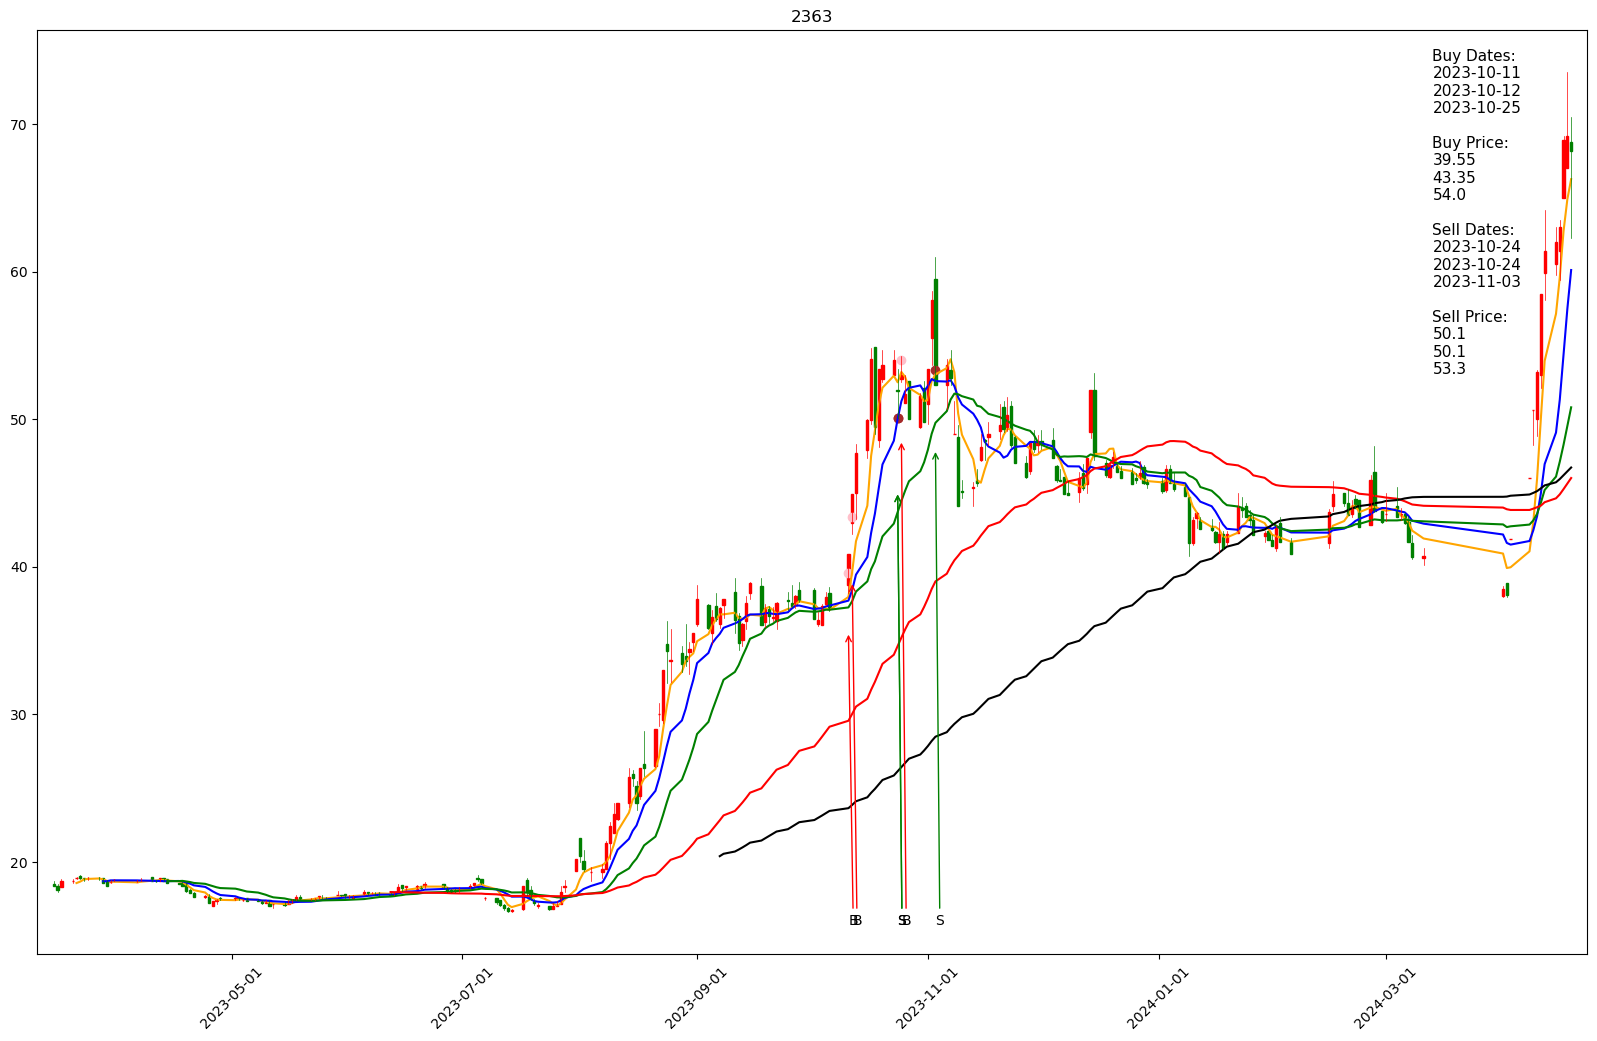

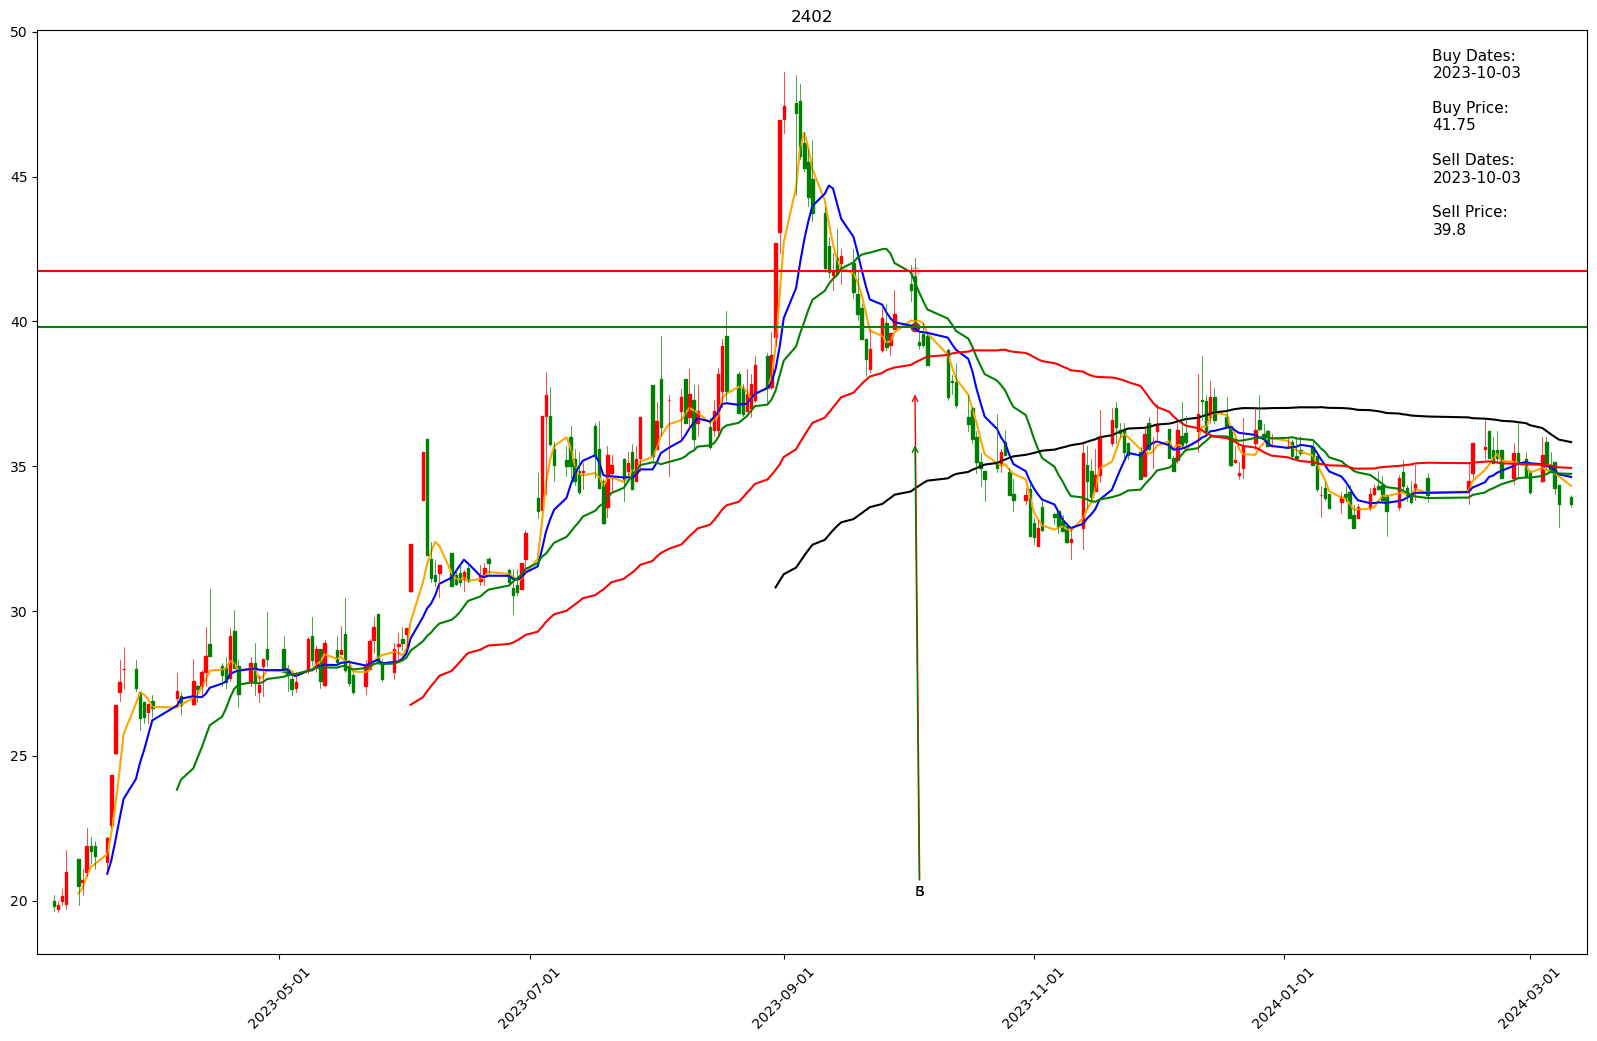

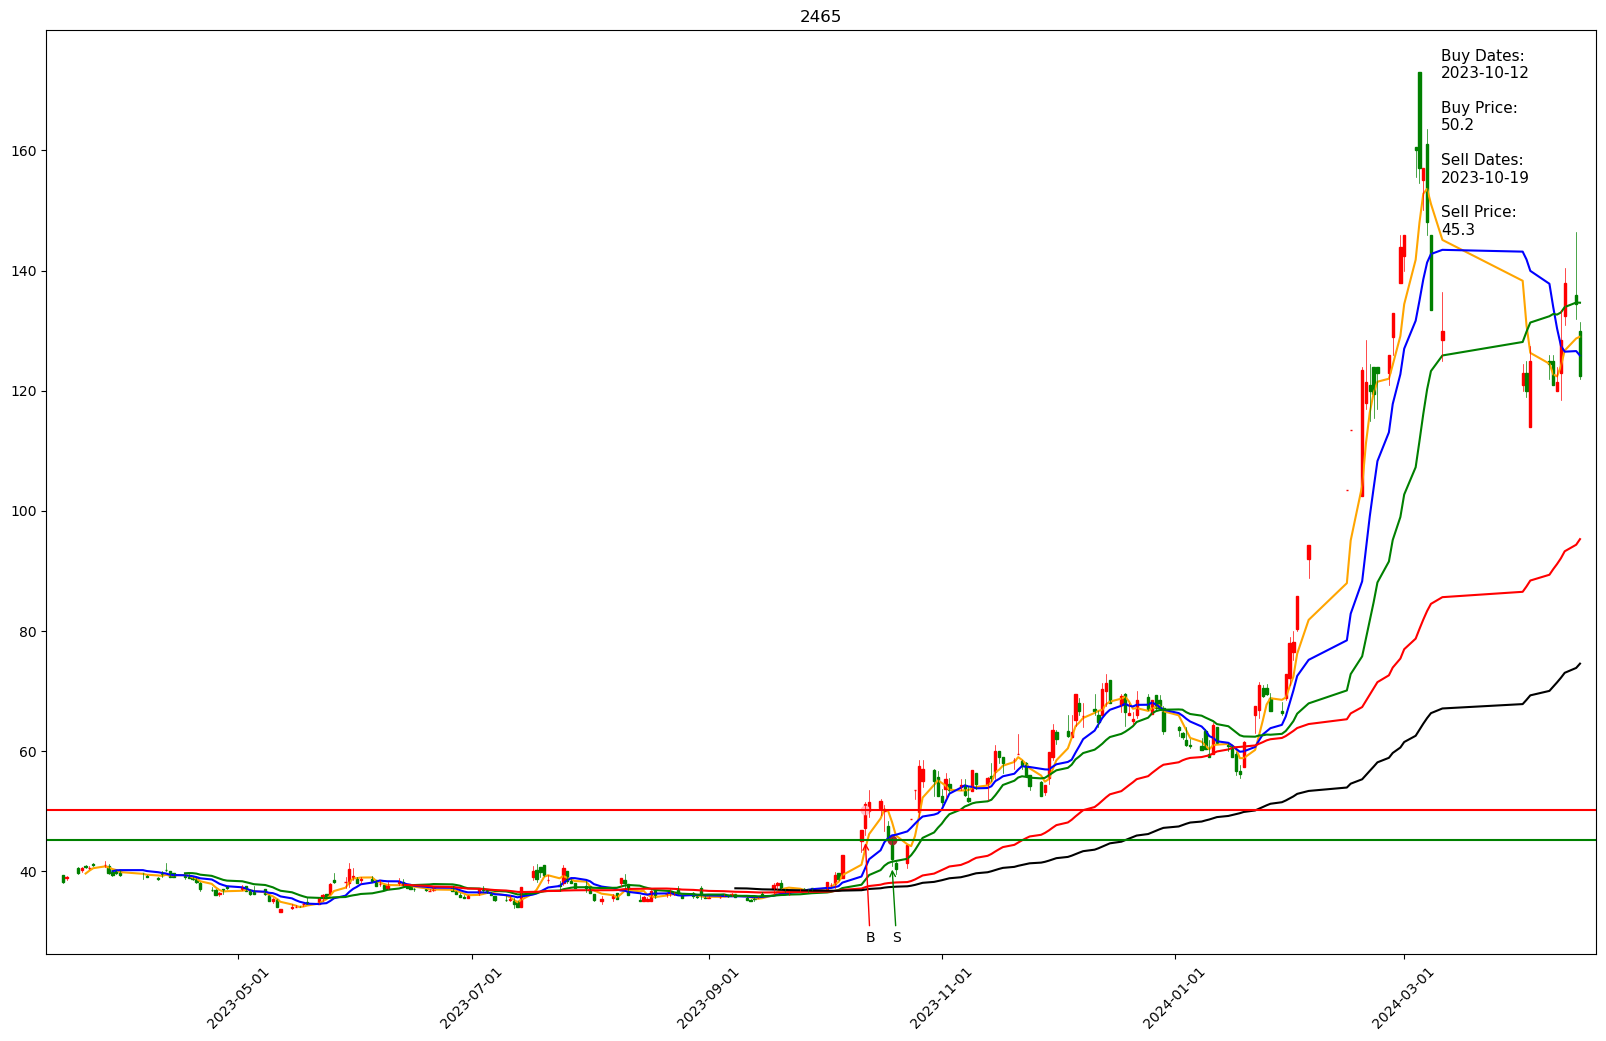

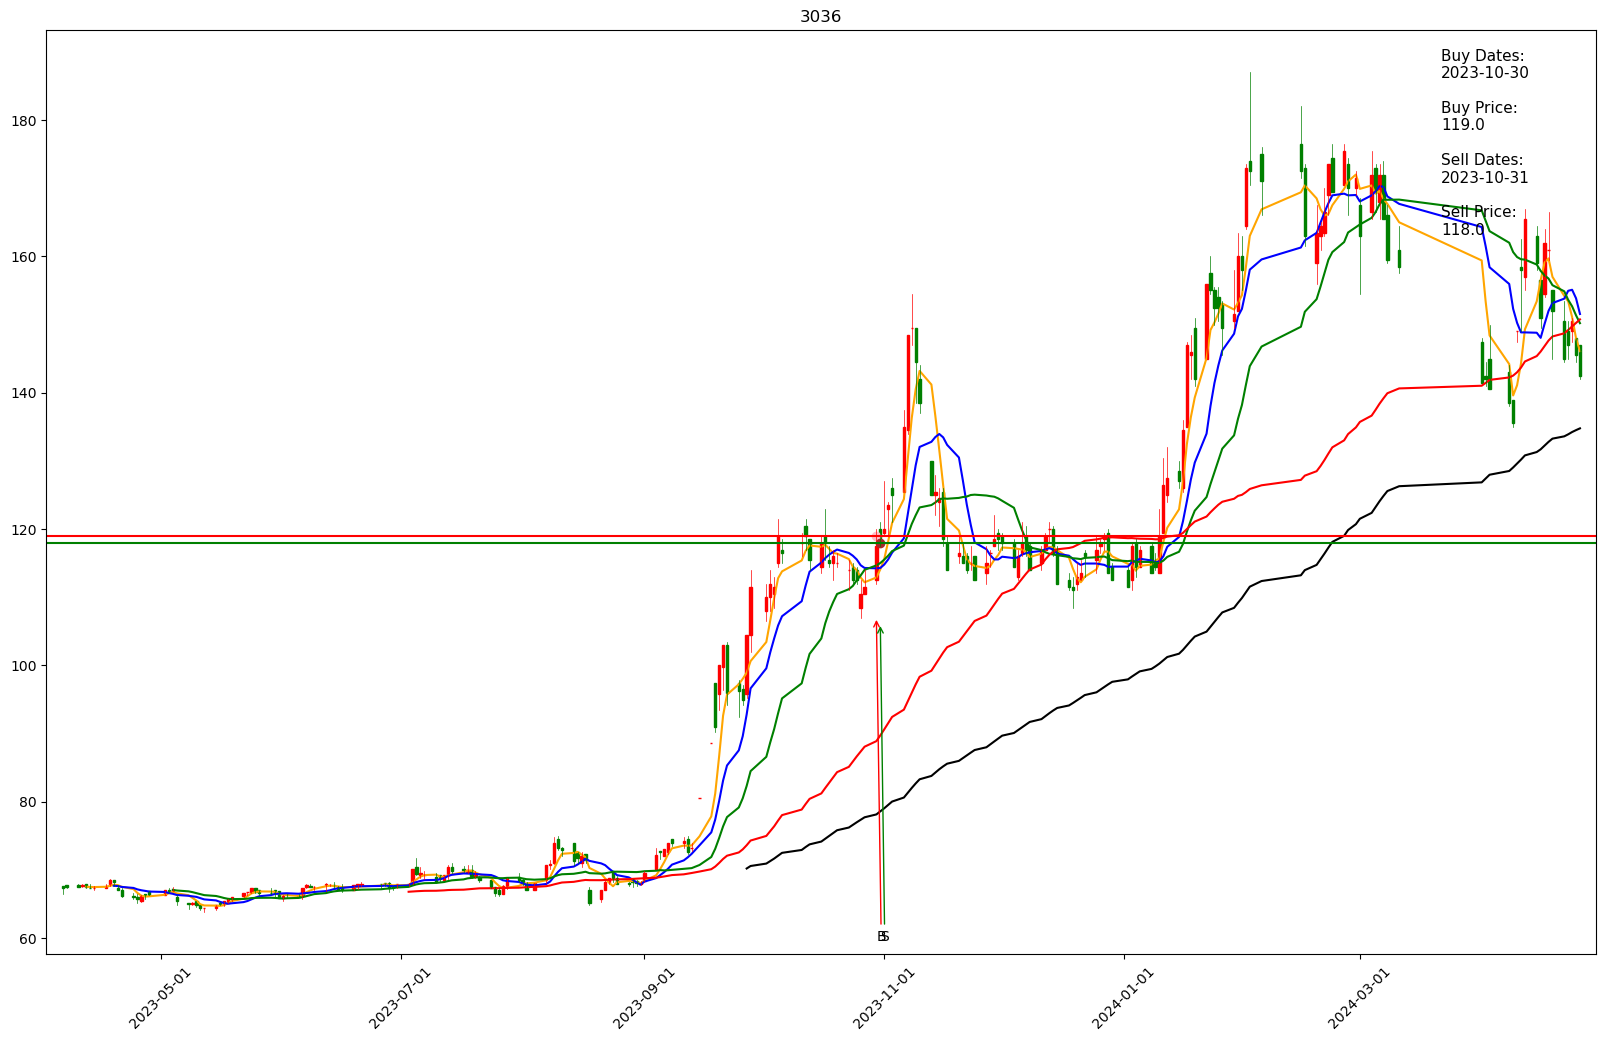

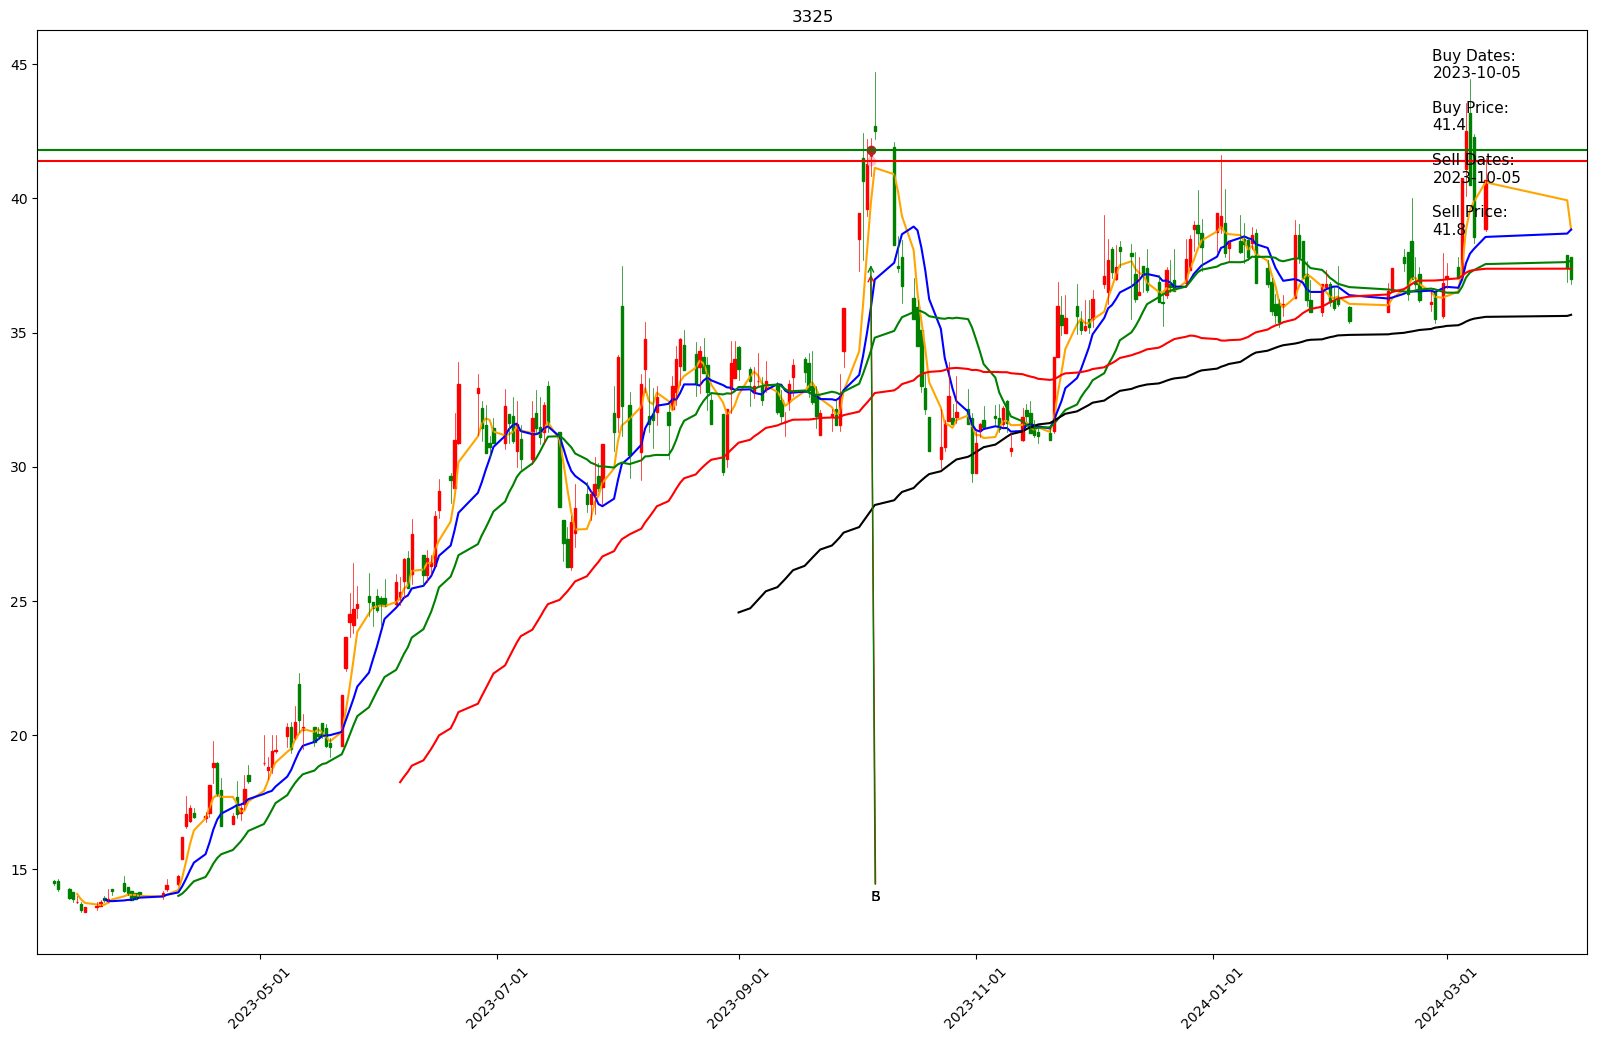

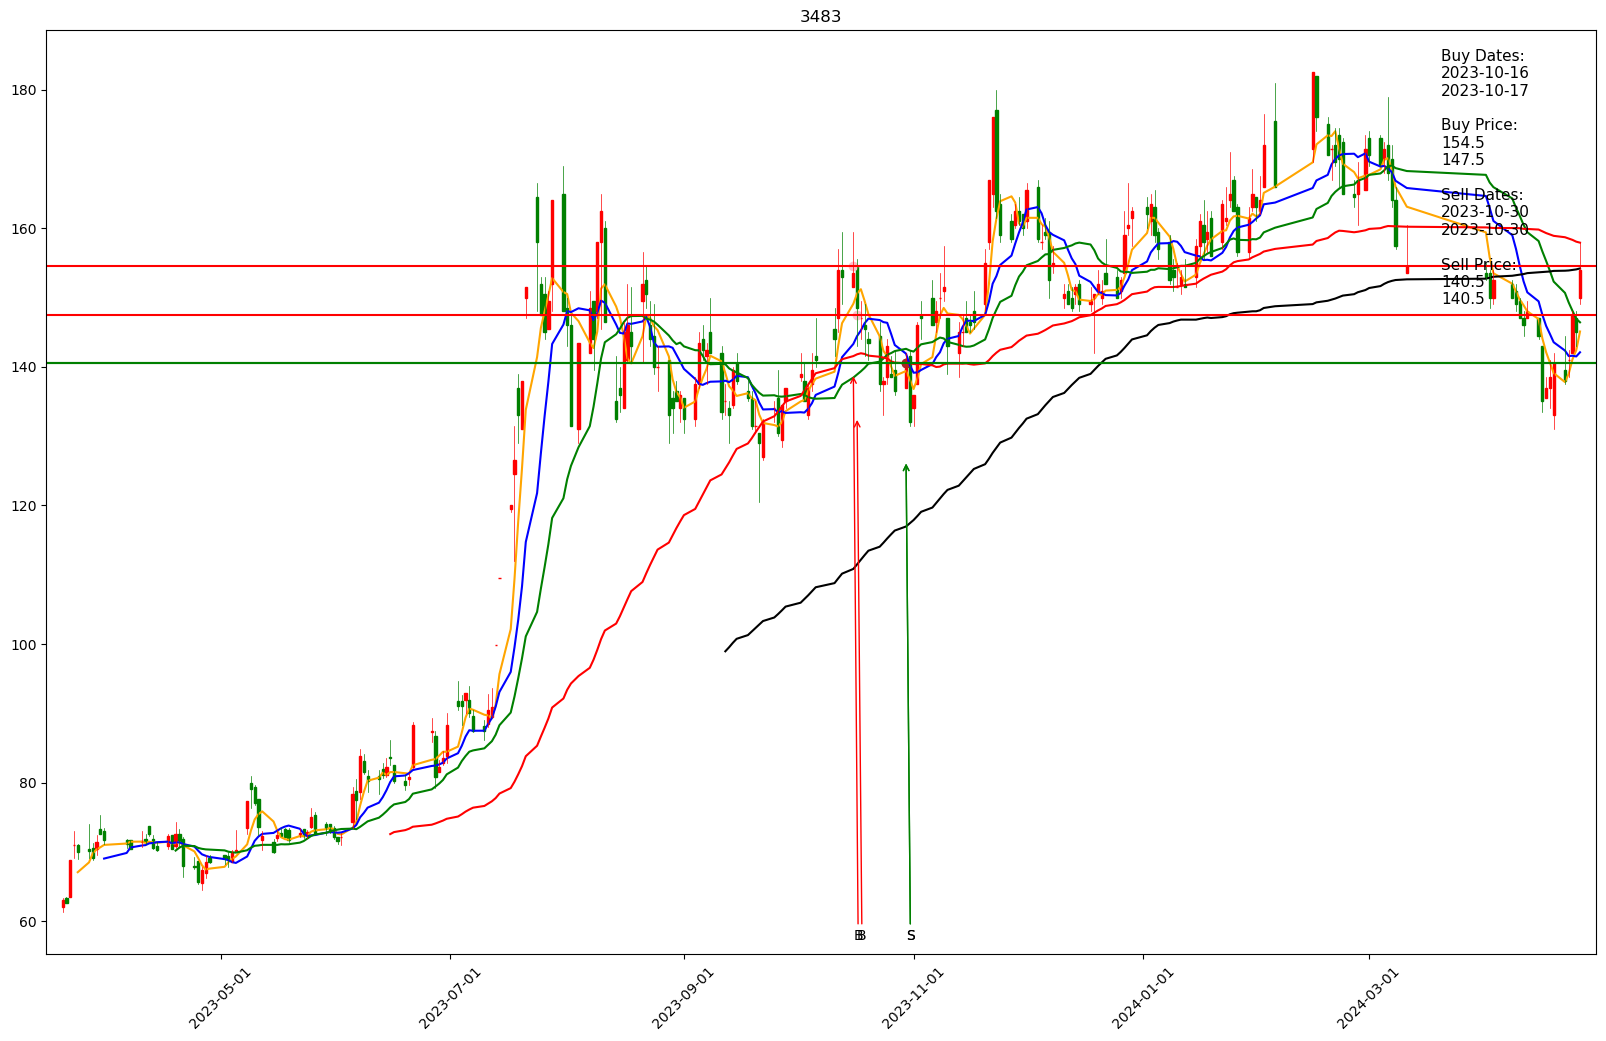

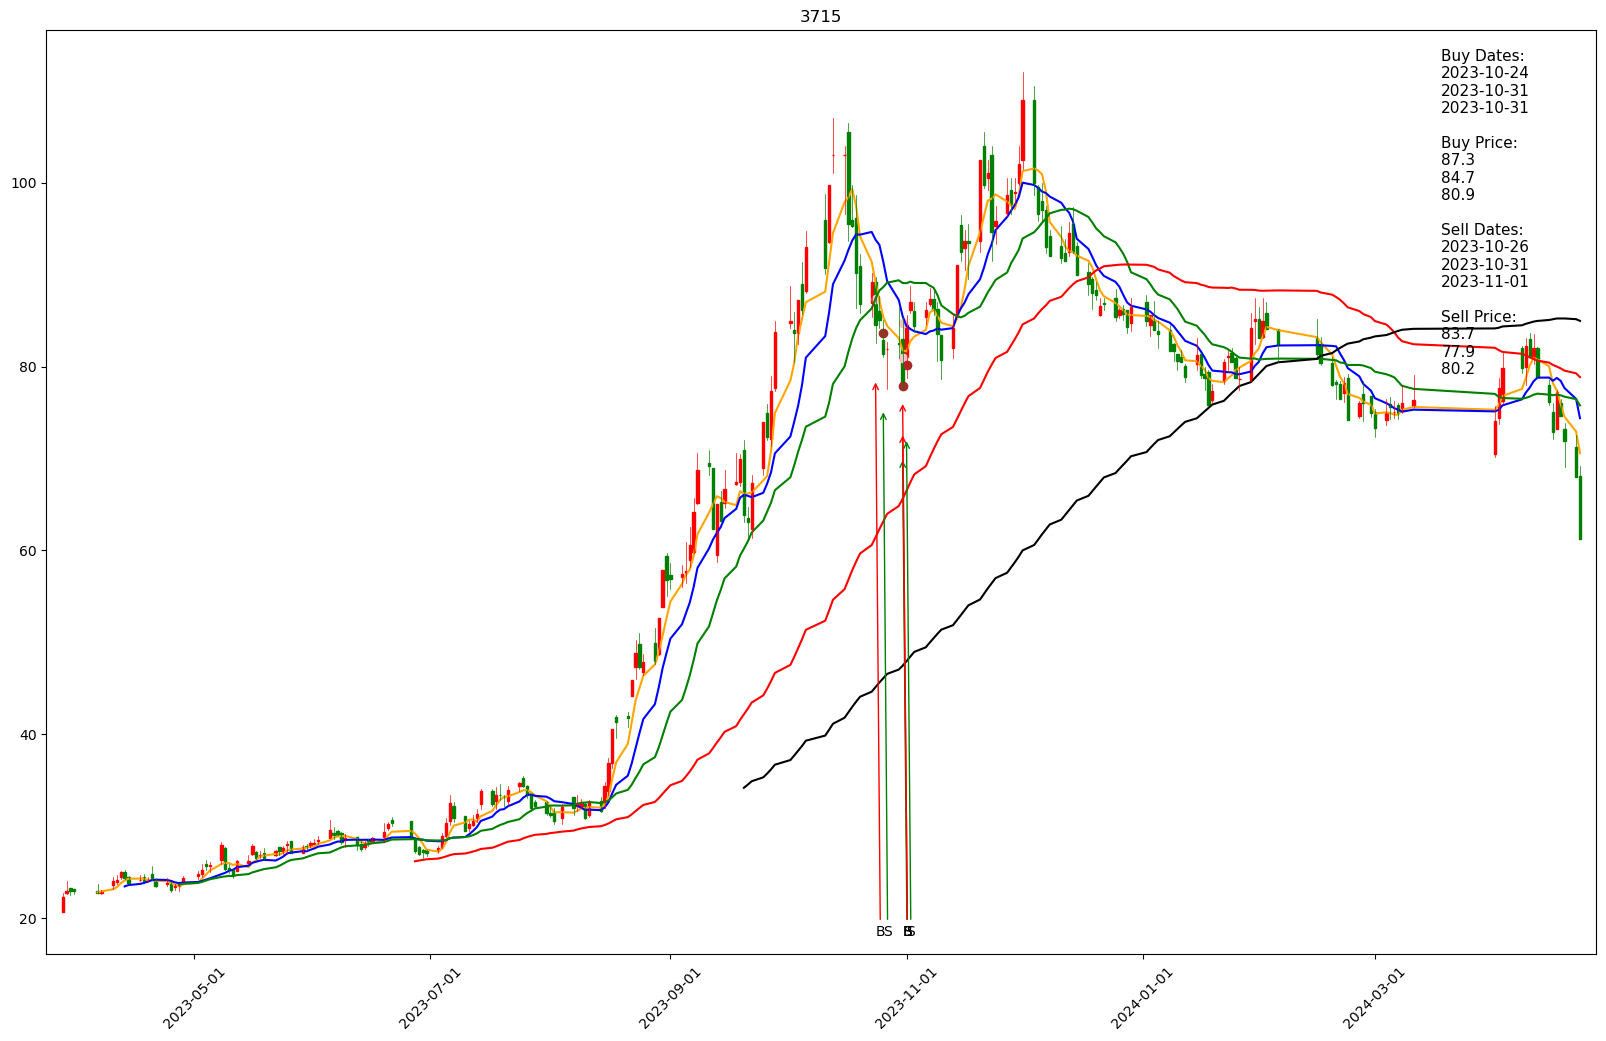

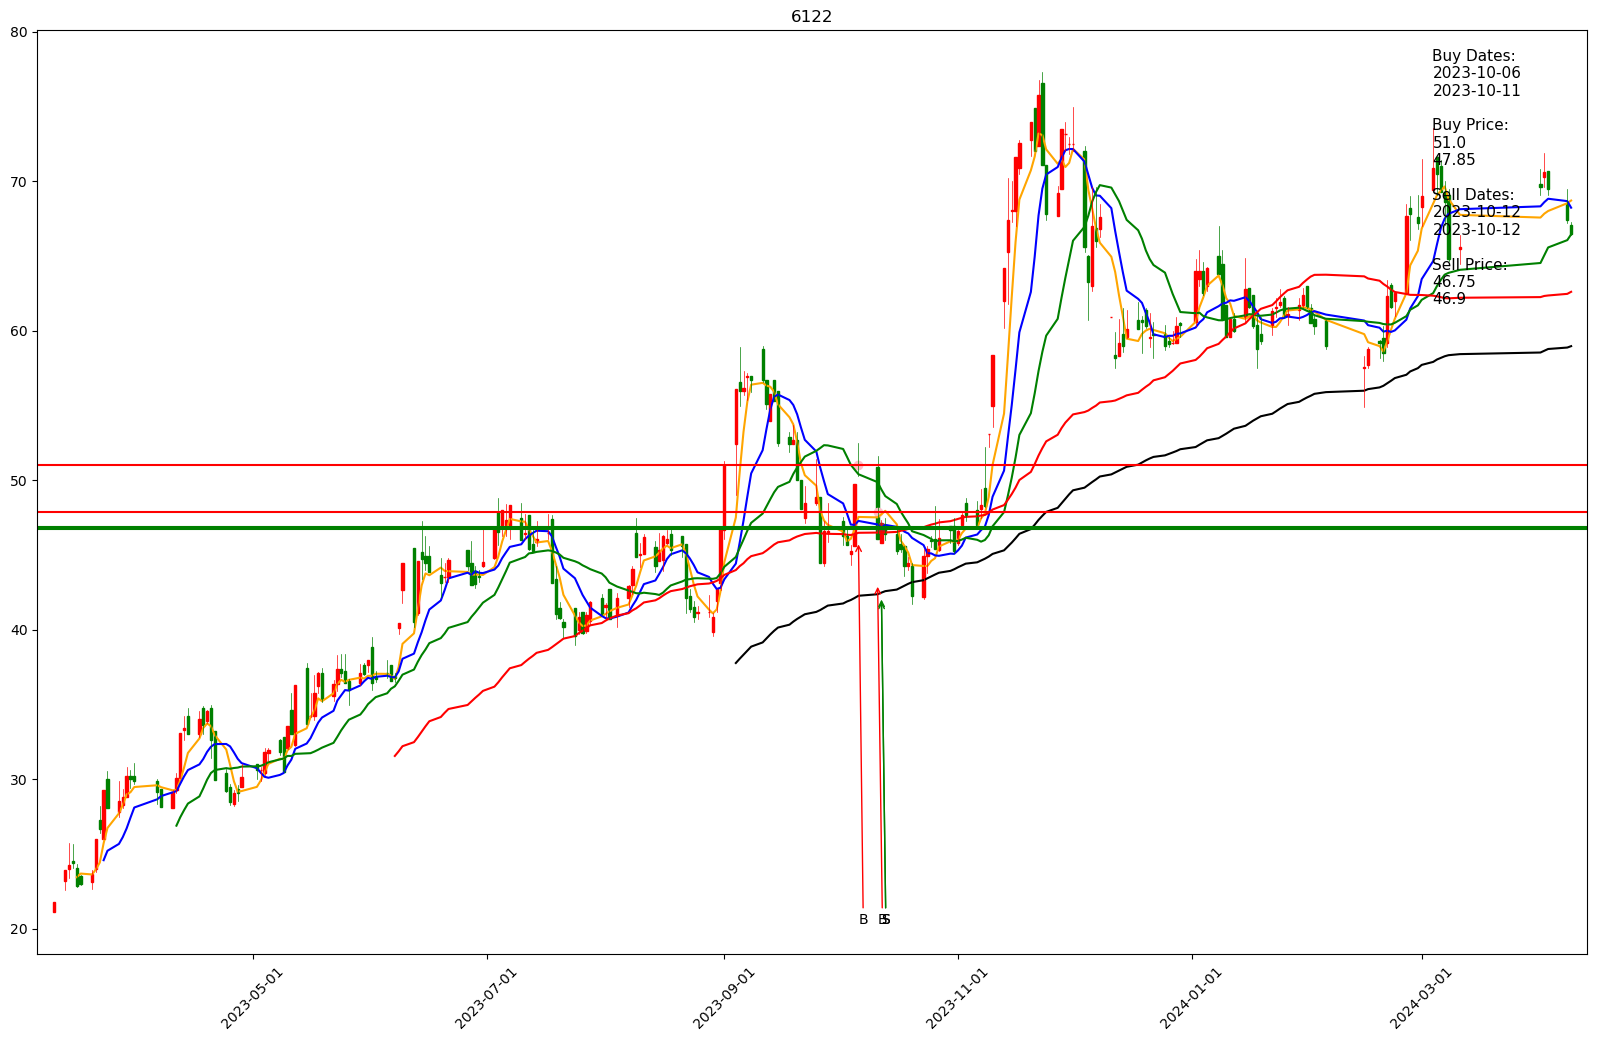

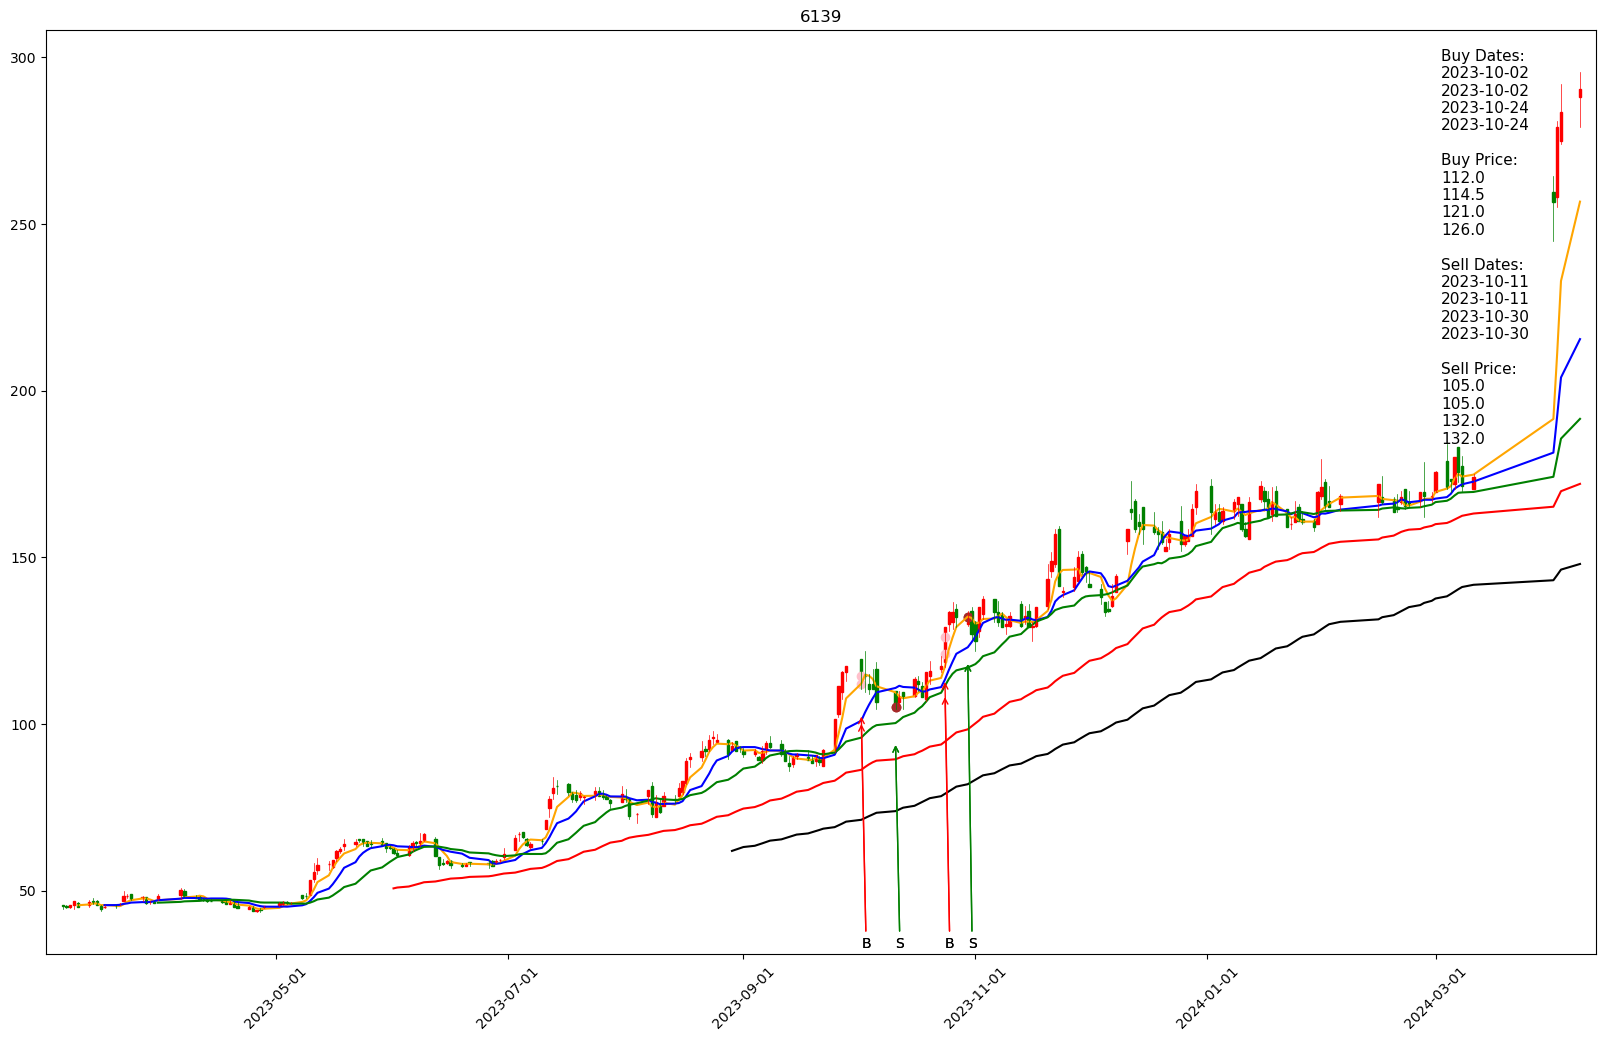

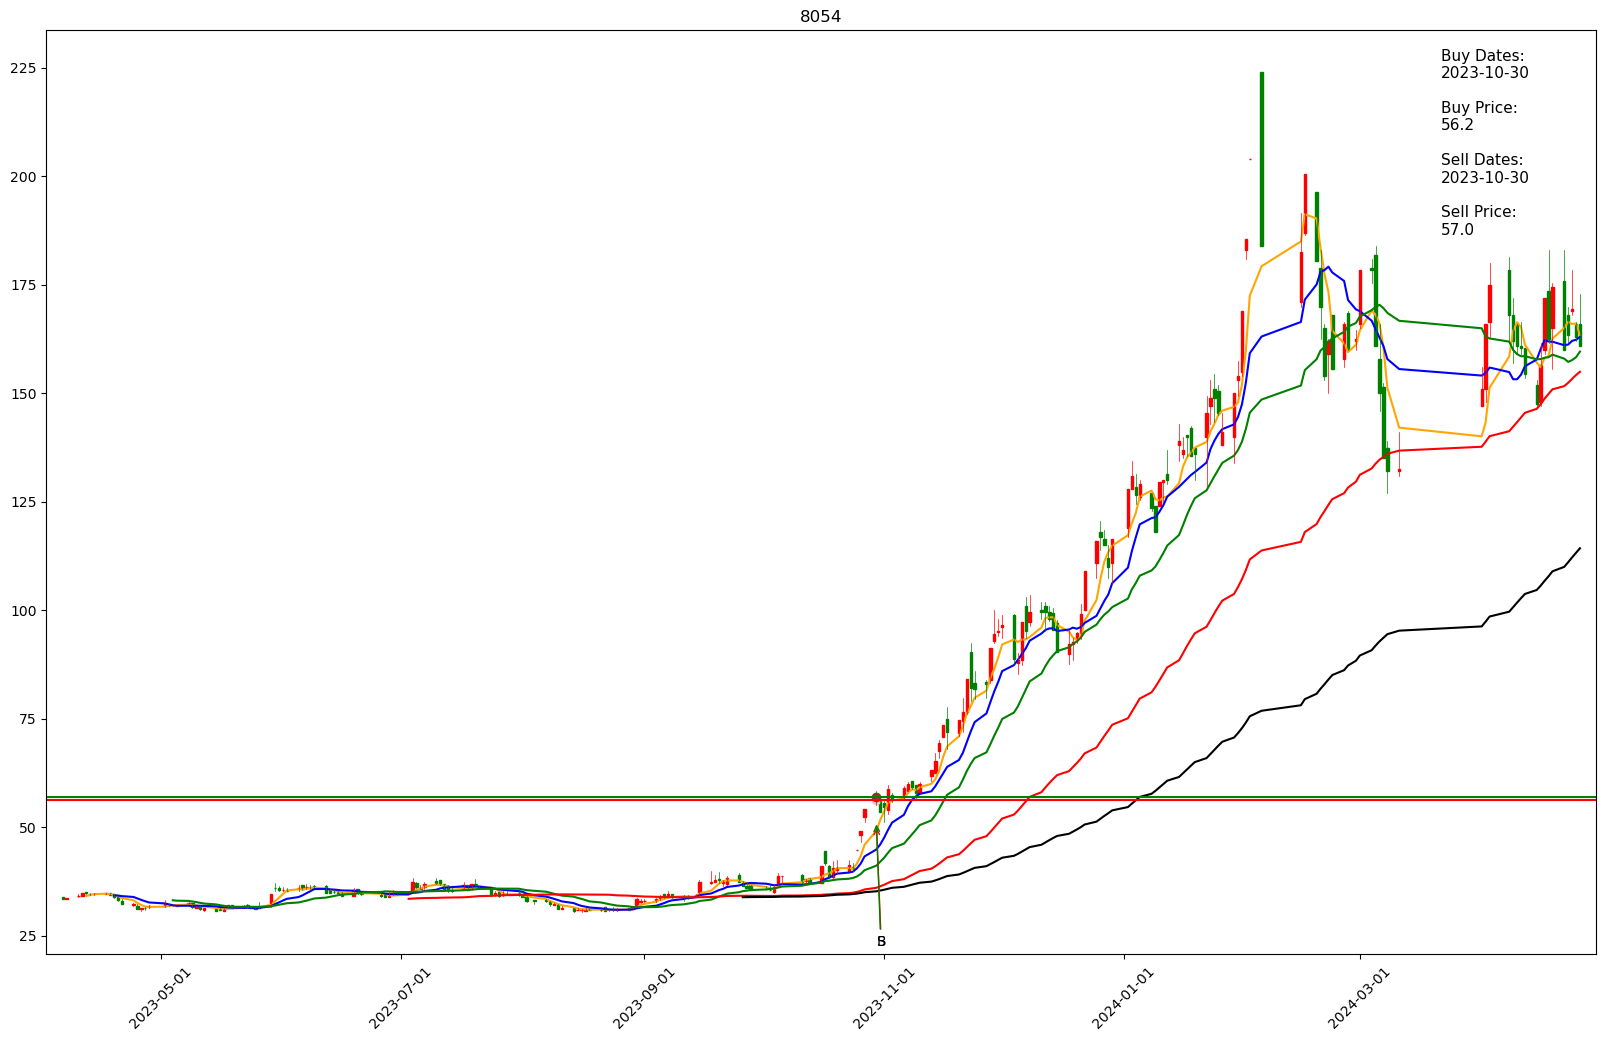

In [10]:
#取得kbars函式
def get_stock_kbars(trades_df):
    stock_code=str(trades_df.iloc[0].stock_code)
    buy_date=trades_df.iloc[0].buy_date.date()
    sell_date=trades_df.iloc[0].sell_date.date()
    delta_180 = timedelta(days=180)
    delta_210 = timedelta(days=210)

    start_day = (buy_date-delta_210).strftime('%Y-%m-%d')
    end_day = (sell_date+delta_180).strftime('%Y-%m-%d')


    # 取得股票代碼的合約
    contract = api.Contracts.Stocks[stock_code]

    # 取得股票的 K 線資料
    kbars = api.kbars(contract, start=start_day, end=end_day)

    kbars_df = pd.DataFrame({**kbars})
    kbars_df.ts = pd.to_datetime(kbars_df.ts)
    # 將 ts 欄位從分鐘轉換為天
    kbars_df.set_index('ts',inplace=True)
    kbars_df = kbars_df.resample('D').ohlc().dropna()
    

    daily_kbars = kbars_df.loc[:, [('Open', 'open'), ('High','high'),('Low','low'),('Close', 'close'),]]
    new_cloumns_name = ['Open_price','High_price','Low_price','Close_price']
    daily_kbars.columns=new_cloumns_name
 

    
    return daily_kbars

# 取得買賣圖的函式
def get_trade_plt(daily_kbars,trades_df):
    # 計算均線值
    daily_kbars['MA5']= daily_kbars['Close_price'].rolling(window=5).mean().dropna()
    daily_kbars['MA10'] = daily_kbars['Close_price'].rolling(window=10).mean().dropna()
    daily_kbars['MA20'] = daily_kbars['Close_price'].rolling(window=20).mean().dropna()
    daily_kbars['MA60'] = daily_kbars['Close_price'].rolling(window=60).mean().dropna()
    daily_kbars['MA120'] = daily_kbars['Close_price'].rolling(window=120).mean().dropna()

    # 繪製 K 線圖
    fig = plt.figure(figsize=(20, 12))  # 设置画布大小为宽10高6
    ax = fig.add_subplot(111)  # 添加一个子图

    # 繪製均線
    ax.plot(daily_kbars.index, daily_kbars['MA5'], label='MA5', color='orange')
    ax.plot(daily_kbars.index, daily_kbars['MA10'], label='MA10', color='blue')
    ax.plot(daily_kbars.index, daily_kbars['MA20'], label='MA20', color='green')
    ax.plot(daily_kbars.index, daily_kbars['MA60'], label='MA60', color='red')
    ax.plot(daily_kbars.index, daily_kbars['MA120'], label='MA120', color='black')
    candlestick_ohlc(ax, zip(mdates.date2num(daily_kbars.index), daily_kbars['Open_price'], daily_kbars['High_price'], daily_kbars['Low_price'], daily_kbars['Close_price']), width=0.6, colorup='r', colordown='g')
    ax.margins(x=0.01)  # 增加 x 方向的間距

   
     
    # 繪製交易點位
    ax.scatter(trades_df['buy_date'], trades_df['buy_price'], color='pink', label='Buy')
    ax.scatter(trades_df['sell_date'], trades_df['sell_price'], color='brown', label='Sell')
    # 在圖上畫水平線
    for buy_price in trades_df['buy_price']:
        if(len(trades_df)>2):
            pass
        else:
            ax.axhline(y=buy_price, color='red', linestyle='-', label='Buy Price')
    for sell_price in trades_df['sell_price']:
        if(len(trades_df)>2):
            pass
        else:
            ax.axhline(y=sell_price, color='green', linestyle='-', label='Sell Price')

    # 取 y 轴的最小值
    y_min, y_max = ax.get_ylim()

    # 繪製交易點位
    for index, trade in trades_df.iterrows():
        buy_date = trade['buy_date']
        buy_price = trade['buy_price']
        sell_date = trade['sell_date']
        sell_price = trade['sell_price']

        # 繪製買點箭頭
        ax.annotate('B', xy=(buy_date, buy_price-(buy_price*0.1)), xytext=(buy_date, y_min+2), arrowprops=dict(color='red', arrowstyle='->'))
       
        # 繪製賣點箭頭
        ax.annotate('S', xy=(sell_date, sell_price-(sell_price*0.1)), xytext=(sell_date, y_min+2), arrowprops=dict(color='green', arrowstyle='->'))

        
    # 設置 x 軸日期格式
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

   

   # 將買賣日期轉換為字串列表，並格式化日期
    buy_dates = '\n'.join([date.strftime('%Y-%m-%d') for date in trades_df['buy_date']])
    sell_dates = '\n'.join([date.strftime('%Y-%m-%d') for date in trades_df['sell_date']])
    buy_prices = '\n'.join([str(price) for price in trades_df['buy_price']])
    sell_prices = '\n'.join([str(price) for price in trades_df['sell_price']])
    
    # 添加左上角文本標籤
    ax.text(0.90, 0.98, f"Buy Dates:\n{buy_dates}\n\nBuy Price:\n{buy_prices}\n\nSell Dates:\n{sell_dates}\n\nSell Price:\n{sell_prices}", transform=ax.transAxes, fontsize=11, verticalalignment='top')
    # 傾斜 x 軸標籤
    plt.xticks(rotation=45)

    # 添加圖例
    # plt.legend()

    # 添加標題
    stock_code=trades_df.iloc[0].stock_code
    plt.title(stock_code)

    # 確定當前工作目錄
    current_directory = os.getcwd()
    
    # 將圖片保存到當前工作目錄中的 "images" 子目錄
    image_directory = os.path.join(current_directory, f'images_{csv_file_name}')
    os.makedirs(image_directory, exist_ok=True)  # 如果目錄不存在，則創建它
    # 定義 JPEG 檔案名稱的變數
    jpg_filename = str(stock_code)+'.jpg'
    # 圖片的完整路徑
    image_path = os.path.join(image_directory, jpg_filename)
    
    # 保存圖表為 JPEG 檔案
    plt.savefig(image_path, format='jpg')
    
    # 顯示圖表
    plt.show()

#for迴圈抓dfs,抓stock_code然後查kbars
for trades_df in dfs:
    daily_kbars = get_stock_kbars(trades_df)
    get_trade_plt(daily_kbars,trades_df)

Kbars(ts=[1705309260000000000, 1705309320000000000, 1705309380000000000, 1705309440000000000, 1705309500000000000, 1705309560000000000, 1705309620000000000, 1705309680000000000, 1705309740000000000, 1705309800000000000, 1705309860000000000, 1705309920000000000, 1705309980000000000, 1705310040000000000, 1705310100000000000, 1705310160000000000, 1705310220000000000, 1705310280000000000, 1705310340000000000, 1705310400000000000, 1705310460000000000, 1705310520000000000, 1705310580000000000, 1705310640000000000, 1705310700000000000, 1705310760000000000, 1705310820000000000, 1705310880000000000, 1705310940000000000, 1705311000000000000, 1705311060000000000, 1705311120000000000, 1705311180000000000, 1705311240000000000, 1705311300000000000, 1705311360000000000, 1705311420000000000, 1705311480000000000, 1705311540000000000, 1705311600000000000, 1705311660000000000, 1705311720000000000, 1705311780000000000, 1705311840000000000, 1705311900000000000, 1705311960000000000, 1705312020000000000, 170